# ☕ Análise de Vendas de Café
# Dataset: `coffee_sales.csv` – Vendas de uma cafeteria (2024–2025)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime

In [2]:
# Configurações de estilo

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [4]:
# Leitura do arquivo

with open('../data/coffee_sales.csv', 'r') as f:
    raw_data = f.read()

In [6]:
# Expressão regular para extrair registros

pattern = r'(\d{4}-\d{2}-\d{2}),(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d{3}),(card|cash),([^,]*),([\d.]+),([^,]+?)(?=\d{4}-\d{2}-\d{2}|$)'
matches = re.findall(pattern, raw_data)

In [7]:
# Criação do DataFrame

df = pd.DataFrame(matches, columns=['Date', 'Timestamp', 'Payment Method', 'Customer ID', 'Price', 'Product'])


In [8]:
# Conversão de tipos

df['Date'] = pd.to_datetime(df['Date'])
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Price'] = df['Price'].astype(float)
df['Product'] = df['Product'].str.strip()

print(f"✅ {len(df)} registros carregados.")

✅ 3636 registros carregados.


In [9]:
# Informações gerais

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3636 entries, 0 to 3635
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            3636 non-null   datetime64[ns]
 1   Timestamp       3636 non-null   datetime64[ns]
 2   Payment Method  3636 non-null   object        
 3   Customer ID     3636 non-null   object        
 4   Price           3636 non-null   float64       
 5   Product         3636 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 170.6+ KB


,Date,Timestamp,Payment Method,Customer ID,Price,Product
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


In [10]:
# Estatísticas descritivas

df.describe()

,Date,Timestamp,Price
count,3636,3636,3636.000000
mean,2024-09-30 11:56:02.376237568,2024-10-01 02:35:30.535053568,31.746859
min,2024-03-01 00:00:00,2024-03-01 10:15:50.520000,18.120000
25%,2024-07-03 00:00:00,2024-07-03 16:54:06.084750080,27.920000
50%,2024-10-06 12:00:00,2024-10-07 02:55:12.649500160,32.820000
75%,2025-01-08 00:00:00,2025-01-08 07:55:20.299750144,35.760000
max,2025-03-23 00:00:00,2025-03-23 18:11:38.635000,40.000000
std,NaN,NaN,4.919926


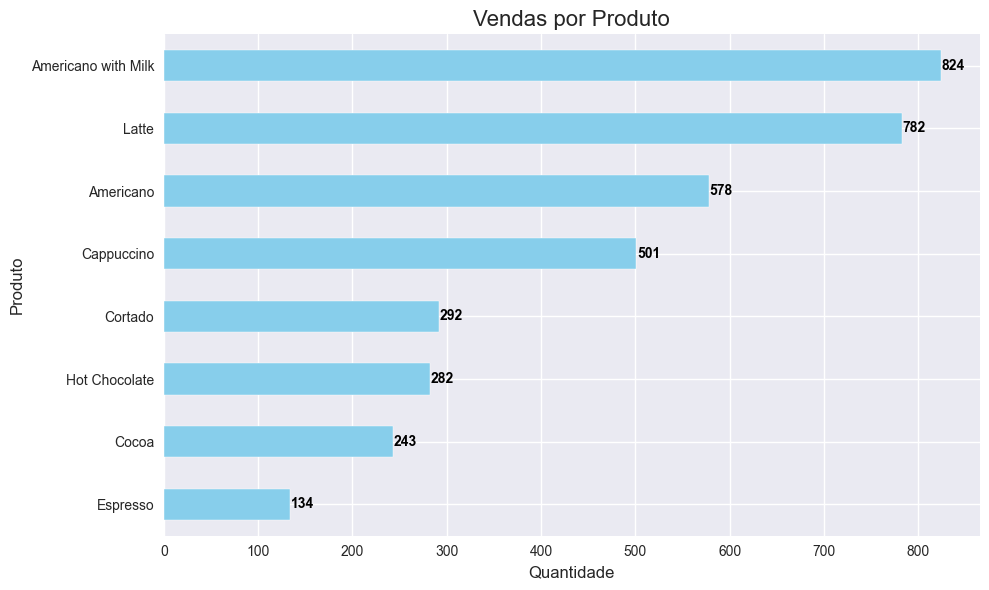

In [21]:
# Produtos mais vendidos

import os
plt.figure(figsize=(10, 6))

ax = df['Product'].value_counts().plot(kind='barh', color='skyblue')

plt.title('Vendas por Produto', fontsize=16)
plt.xlabel('Quantidade', fontsize=12)
plt.ylabel('Produto', fontsize=12)

for index, value in enumerate(df['Product'].value_counts().values):
    ax.text(value + 0.5, index, str(value), va='center', fontsize=10, color='black', fontweight='bold')

ax.invert_yaxis()
plt.tight_layout()

os.makedirs('../outputs/figures', exist_ok=True)
plt.savefig('../outputs/figures/sales_by_product.png', dpi=150)

plt.show()

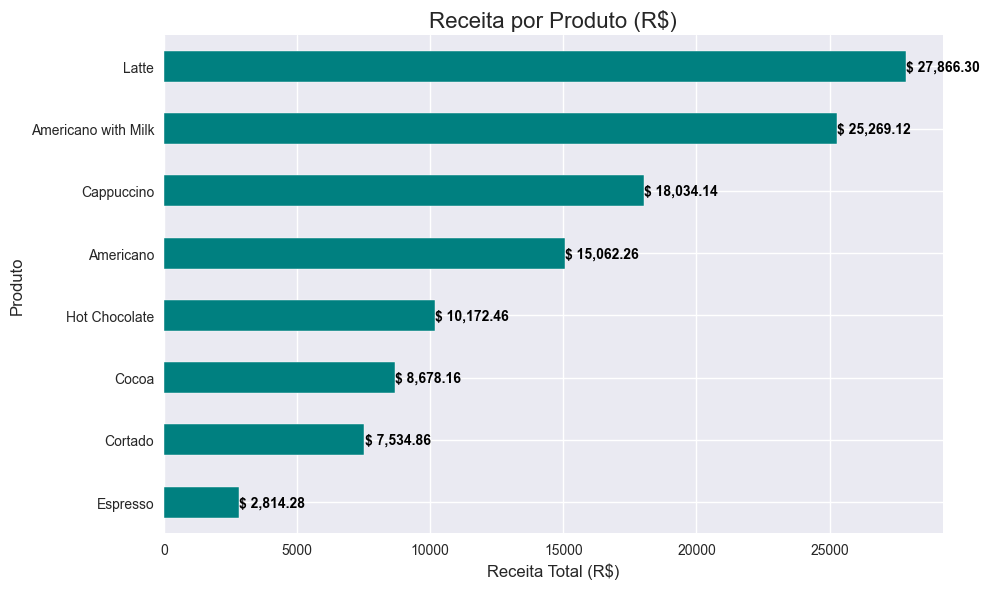

In [27]:
# Receita por produto com valores visíveis

plt.figure(figsize=(10, 6))

ax = df.groupby('Product')['Price'].sum().sort_values().plot(kind='barh', color='teal')

plt.title('Receita por Produto (R$)', fontsize=16)
plt.xlabel('Receita Total (R$)', fontsize=12)
plt.ylabel('Produto', fontsize=12)

revenue = df.groupby('Product')['Price'].sum().sort_values()
for index, value in enumerate(revenue):
    ax.text(value + 0.5, index, f'$ {value:,.2f}', va='center', fontsize=10, color='black', fontweight='bold')

plt.tight_layout()

os.makedirs('../outputs/figures', exist_ok=True)
plt.savefig('../outputs/figures/revenue_by_product.png', dpi=150)

plt.show()

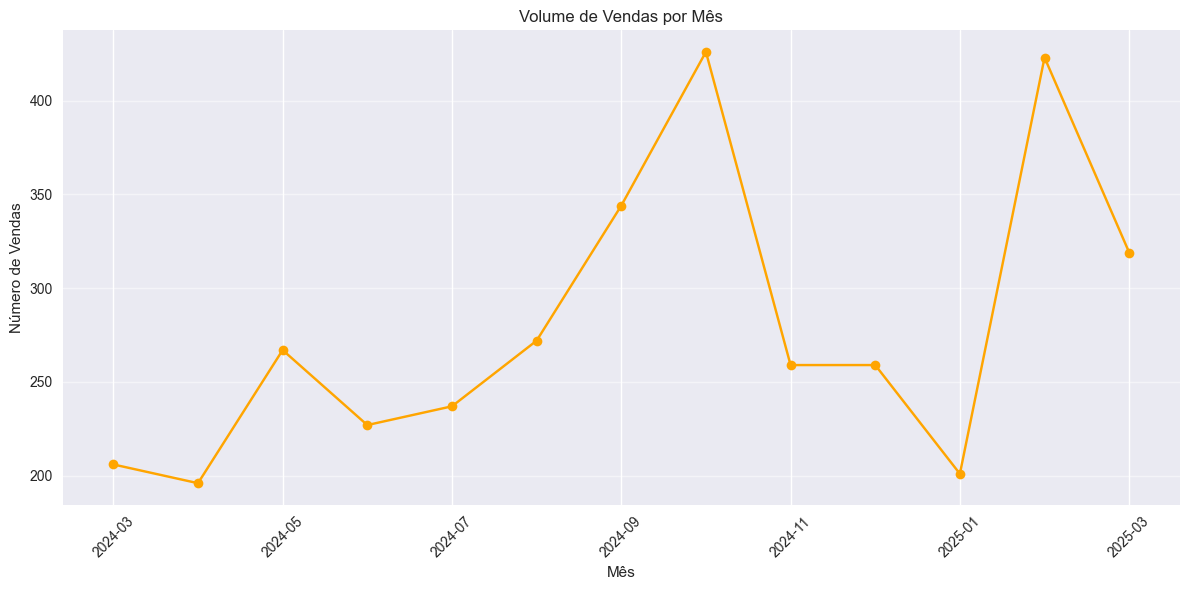

In [23]:
# Evolução mensal de vendas

df['Month'] = df['Date'].dt.to_period('M')
monthly_sales = df.groupby('Month').size()
monthly_sales.index = monthly_sales.index.astype(str)

plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='line', marker='o', color='orange')
plt.title('Volume de Vendas por Mês')
plt.xlabel('Mês')
plt.ylabel('Número de Vendas')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.savefig('../outputs/figures/sales_over_time.png', dpi=150)
plt.show()

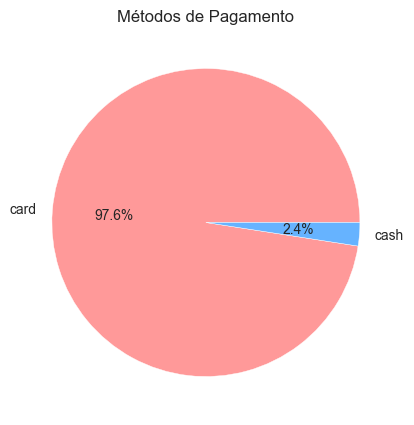

In [28]:
# Métodos de pagamento

payment = df['Payment Method'].value_counts()
plt.figure(figsize=(7, 5))
plt.pie(payment, labels=payment.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
plt.title('Métodos de Pagamento')
plt.savefig('../outputs/figures/payment_method.png', dpi=150)
plt.show()

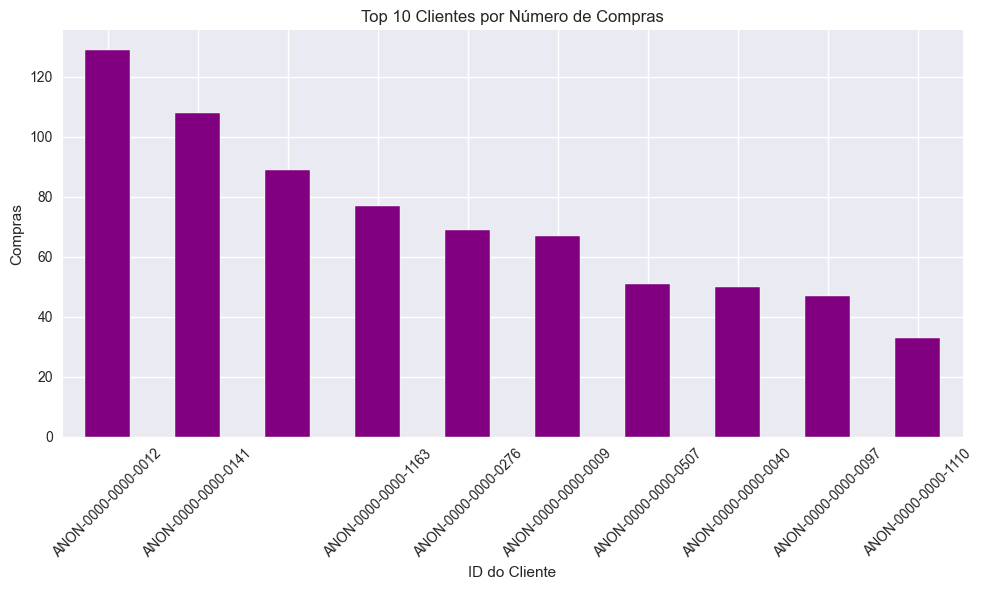

In [29]:
# Top 10 clientes mais frequentes

top_customers = df['Customer ID'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_customers.plot(kind='bar', color='purple')
plt.title('Top 10 Clientes por Número de Compras')
plt.xlabel('ID do Cliente')
plt.ylabel('Compras')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../outputs/figures/top_customers.png', dpi=150)
plt.show()

In [30]:
# Análise do cliente mais fiel
top_customer_id = top_customers.index[0]
top_customer_data = df[df['Customer ID'] == top_customer_id]
print(f"\nCliente mais fiel: {top_customer_id}")
print(top_customer_data['Product'].value_counts())


Cliente mais fiel: ANON-0000-0000-0012
Product
Americano              48
Americano with Milk    30
Espresso               14
Cortado                13
Cocoa                  13
Cappuccino              8
Latte                   3
Name: count, dtype: int64


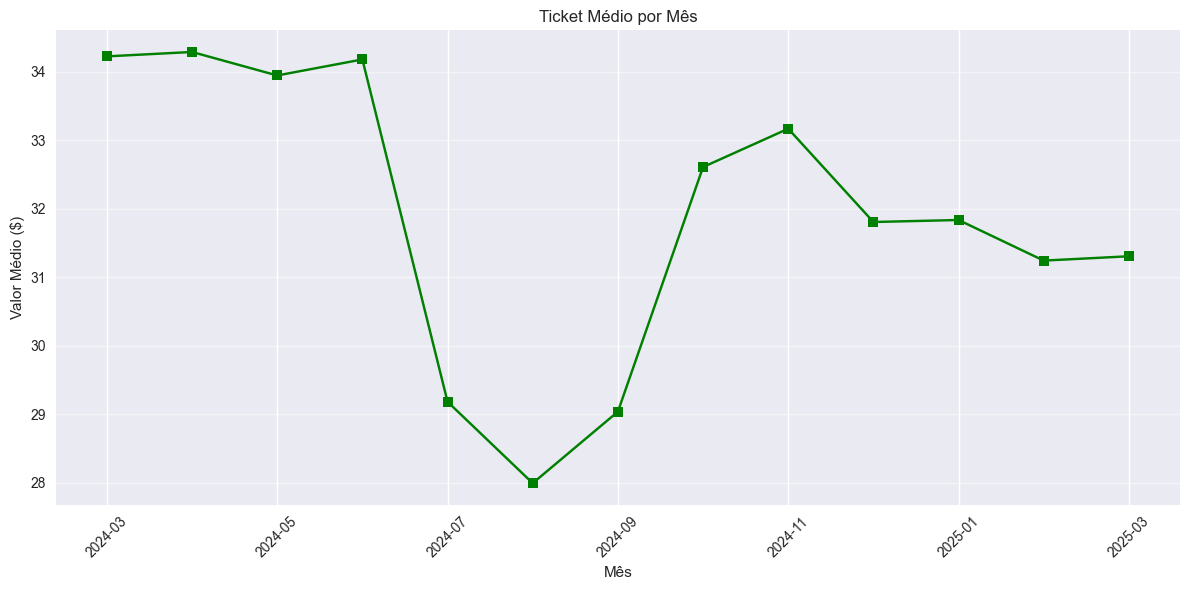

In [32]:
# Ticket médio por mês

avg_ticket = df.groupby('Month')['Price'].mean()
avg_ticket.index = avg_ticket.index.astype(str)
plt.figure(figsize=(12, 6))
avg_ticket.plot(kind='line', marker='s', color='green')
plt.title('Ticket Médio por Mês')
plt.xlabel('Mês')
plt.ylabel('Valor Médio ($)')
plt.grid(axis='y', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../outputs/figures/avg_ticket.png', dpi=150)
plt.show()

In [33]:
# Tabela resumo

summary = df.groupby('Product').agg(
    Quantidade=('Product', 'count'),
    Receita_Total=('Price', 'sum'),
    Preco_Medio=('Price', 'mean')
).round(2).sort_values(by='Receita_Total', ascending=False)

print("\n📊 Tabela Resumo por Produto:")
print(summary)


📊 Tabela Resumo por Produto:
                     Quantidade  Receita_Total  Preco_Medio
Product                                                    
Latte                       782       27866.30        35.63
Americano with Milk         824       25269.12        30.67
Cappuccino                  501       18034.14        36.00
Americano                   578       15062.26        26.06
Hot Chocolate               282       10172.46        36.07
Cocoa                       243        8678.16        35.71
Cortado                     292        7534.86        25.80
Espresso                    134        2814.28        21.00


In [35]:
# Salvar dados limpos
df.to_csv('../outputs/clean_data/coffee_sales_clean.csv', index=False)
print("✅ Dados limpos salvos!")

✅ Dados limpos salvos!


In [36]:
# Resumo final
print(f"""
==================================
📊 RESUMO DA ANÁLISE
==================================
📅 Período: {df['Date'].min().date()} a {df['Date'].max().date()}
🛒 Total de vendas: {len(df)}
🛍️  Produtos distintos: {df['Product'].nunique()}
💳 Pagamento predominante: {df['Payment Method'].value_counts().idxmax()}
⭐ Produto mais vendido: {df['Product'].value_counts().idxmax()}
💰 Produto com maior receita: {revenue.index[0]}
🎫 Ticket médio geral: R$ {df['Price'].mean():.2f}
👥 Clientes únicos: {df['Customer ID'].nunique()}
🔝 Cliente mais fiel: {top_customers.index[0]} ({top_customers.iloc[0]} compras)
""")


📊 RESUMO DA ANÁLISE
📅 Período: 2024-03-01 a 2025-03-23
🛒 Total de vendas: 3636
🛍️  Produtos distintos: 8
💳 Pagamento predominante: card
⭐ Produto mais vendido: Americano with Milk
💰 Produto com maior receita: Espresso
🎫 Ticket médio geral: R$ 31.75
👥 Clientes únicos: 1317
🔝 Cliente mais fiel: ANON-0000-0000-0012 (129 compras)

